In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import BisectingKMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import random
from collections import defaultdict
from sklearn import metrics
from time import time
import numpy as np
import re
from nltk.corpus import stopwords
import unicodedata
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor
import threading
import time

In [2]:
# CSV "2022_Urgencia_texto_limpo.csv" with only one column, without header
# read_csv
justificativas_limpo = pd.read_csv("2022_Urgencia_texto_limpo.csv", sep=";", encoding="latin-1")

print(justificativas_limpo.columns)

justificativas_limpo.dropna(inplace=True)

list_justificativa = justificativas_limpo['justificativa_urgencia_viagem'].tolist()

print(len(list_justificativa))

Index(['justificativa_urgencia_viagem'], dtype='object')
384275


In [3]:
random.seed(42)
list_justificativa = random.sample(list_justificativa, 120000)

print(list_justificativa[:10])

['necessario aguardar confirmacao disponibilidade equipe secex participarao obrigatoriamente evento confirmacao ocorreu hoje', 'necessaria correcao pcdps cadastradas anteriormente', 'servidor substituir pro reitora afastada questoes saude', 'familiar constam cronograma departamento', 'periodo data definidos coordenacao juntamente gabinete pessoal pr', 'informo sr documentos referentes necessidade autorizacao despesas encontram anexos', 'necessidade missao', 'necessidade servico', 'acordo aumento volume trabalho deficit acentuado efetivo coordenacao gestao efetivo coge exposto nota tecnica', 'confirmada prazo legal funcao disponibilidade veiculo oficial servidor designado portaria especifica']


In [4]:
n_comp = 50

In [5]:
count_vectorizer = CountVectorizer(max_df=0.9, min_df=0.01)
X_count = count_vectorizer.fit_transform(list_justificativa)


In [6]:
# lsa_count = make_pipeline(TruncatedSVD(n_components=n_comp), Normalizer(copy=False))
# X_count = lsa_count.fit_transform(X_count)
# explained_variance = lsa_count[0].explained_variance_ratio_.sum()

In [7]:
print(X_count.shape)

(120000, 144)


In [8]:
# count the number of entries > 0
count = (X_count[X_count > 0]).shape[1]
min_k = X_count.shape[0] * X_count.shape[1] // count
max_k = min_k * 3
min_k = min_k // 2


# true_k = 300
# cite https://dl.acm.org/doi/pdf/10.1145/99935.99938
print(min_k, max_k)

21 126


In [9]:
sample = list_justificativa
vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.01)
X = vectorizer.fit_transform(sample)

In [10]:
lsa = make_pipeline(TruncatedSVD(n_components=n_comp, random_state=42), Normalizer(copy=False))
X = lsa.fit_transform(X)
explained_variance = lsa[0].explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance:.2f} for {n_comp} components")

Explained variance of the SVD step: 0.65 for 50 components


In [11]:
res_df = pd.DataFrame(columns=['k', 'inertia', 'silhouette', 'calinski_harabasz', 'davies_bouldin'], index=range(min_k, max_k + 1))

In [12]:
lock = threading.Lock()

In [13]:
def b_kmeans(k):
    km = BisectingKMeans(n_clusters=k, init='k-means++', max_iter=200, n_init=1, random_state=42)
    km.fit(X)
    inertia = km.inertia_
    silhouette = metrics.silhouette_score(X, km.labels_, sample_size=40000)
    calinski_harabasz = metrics.calinski_harabasz_score(X, km.labels_)
    davies_bouldin = metrics.davies_bouldin_score(X, km.labels_)
    
    lock.acquire()
    res_df.loc[k] = [k, inertia, silhouette, calinski_harabasz, davies_bouldin]
    lock.release()

In [16]:
with ThreadPoolExecutor(max_workers=4) as exe:
    exe.map(b_kmeans, range(min_k, max_k + 1))
    
    exe.shutdown(wait=True)

In [25]:
res_df['silhouette'] = res_df['silhouette'].astype(float)
res_df['calinski_harabasz'] = res_df['calinski_harabasz'].astype(float)
res_df['davies_bouldin'] = res_df['davies_bouldin'].astype(float)
res_df['inertia'] = res_df['inertia'].astype(float)

## Elbow Method

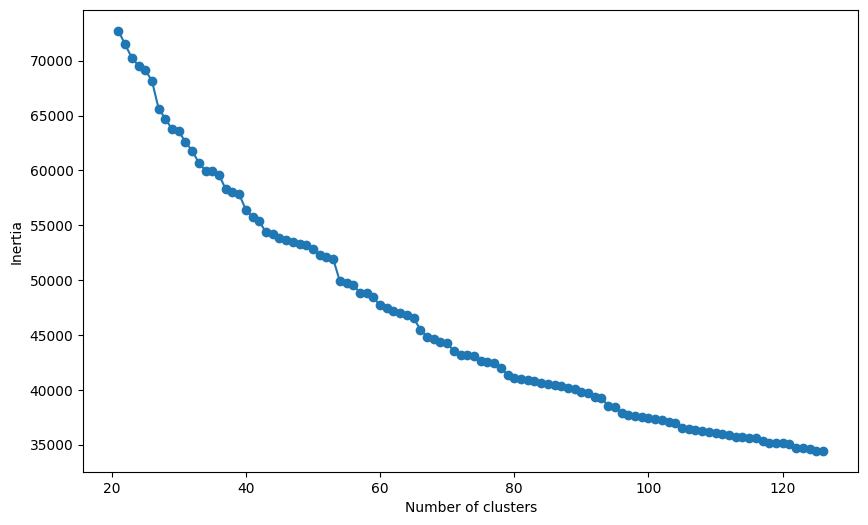

In [26]:
plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['inertia'], marker='o')

plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.show()


## Silhouette Coefficient

In [27]:
# max silhouette
print(res_df.loc[res_df['silhouette'].idxmax()])

k                             124
inertia              34598.519669
silhouette               0.322281
calinski_harabasz     2031.647439
davies_bouldin           2.092739
Name: 124, dtype: object


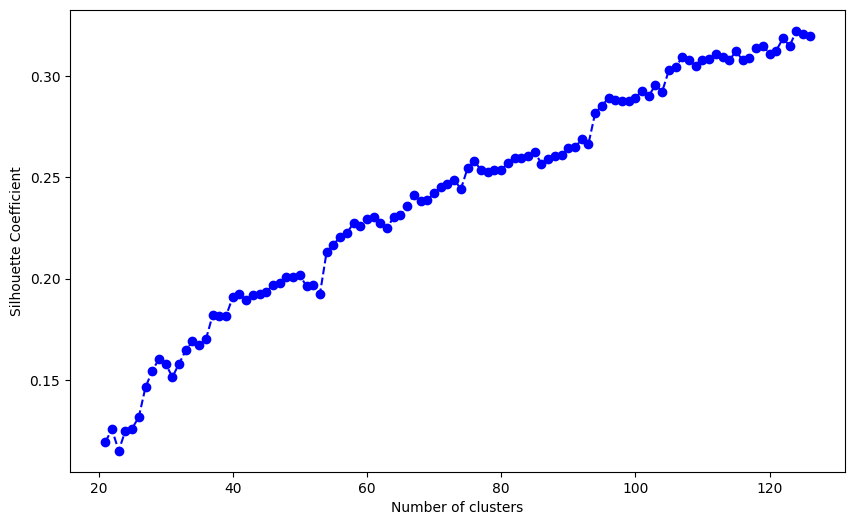

In [20]:
# 2d plot silhouette for each k

plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['silhouette'], marker='o', linestyle='--', color='b')

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

plt.show()



## Calinski-Harabasz Index

In [28]:
# max Calinski-Harabasz
print(res_df.loc[res_df['calinski_harabasz'].idxmax()])

k                              27
inertia              65623.132782
silhouette               0.146458
calinski_harabasz     2890.715851
davies_bouldin           2.467049
Name: 27, dtype: object


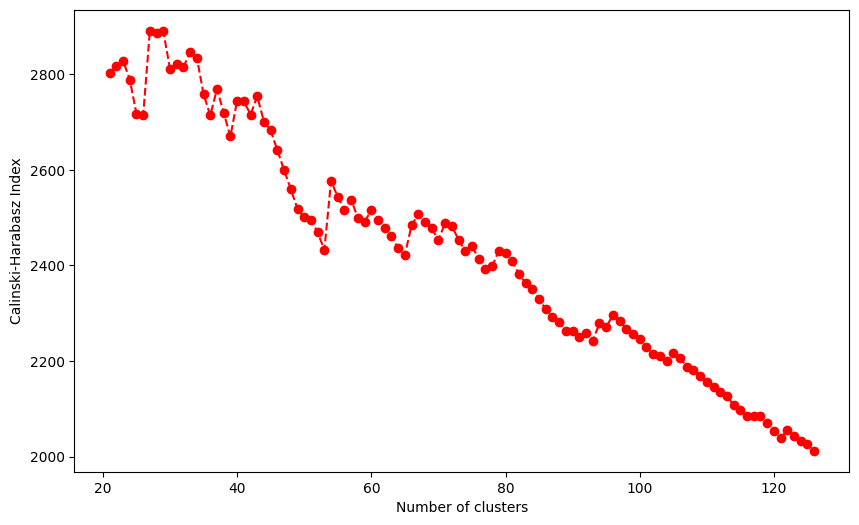

In [29]:
fig = plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['calinski_harabasz'], marker='o', linestyle='--', color='r')

plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')

plt.show()

## Davies-Bouldin Index

In [30]:
# max davies_bouldin
print(res_df.loc[res_df['davies_bouldin'].idxmin()])

k                              97
inertia              37735.583166
silhouette               0.288105
calinski_harabasz     2283.336834
davies_bouldin            2.01257
Name: 97, dtype: object


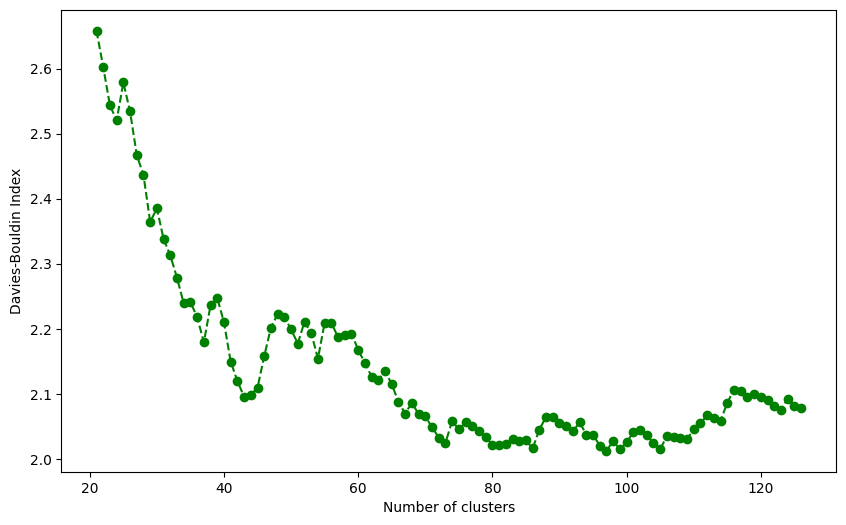

In [31]:
fig = plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['davies_bouldin'], marker='o', linestyle='--', color='g')

plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')

plt.show()

In [32]:
choosen_k = 42

In [33]:
model = BisectingKMeans(n_clusters=choosen_k, init='k-means++', max_iter=200, n_init=1, random_state=42).fit(X)

labels=model.labels_
clusters=pd.DataFrame(list(zip(sample,labels)),columns=['phrase','cluster'])
clusters['cluster'].value_counts()

cluster
13    9936
41    6240
34    5890
29    5292
38    4850
26    4643
37    4459
12    4141
35    3969
32    3892
0     3785
2     3698
8     3414
6     3268
27    2965
25    2884
3     2804
10    2753
22    2716
24    2700
1     2613
11    2611
39    2548
20    2344
9     2303
5     2302
4     2201
40    2062
19    2062
17    1968
16    1786
23    1491
36    1373
7     1321
18    1226
15    1182
30    1132
21     960
28     901
33     707
14     438
31     170
Name: count, dtype: int64

In [34]:
# quantize the clusters
clusters_count = clusters.groupby('cluster').count()
clusters_count = clusters_count.sort_values(by=['phrase'], ascending=False)

clusters_count.head(10)

,phrase
cluster,
13,9936
41,6240
34,5890
29,5292
38,4850
26,4643
37,4459
12,4141
35,3969


<Axes: xlabel='phrase'>

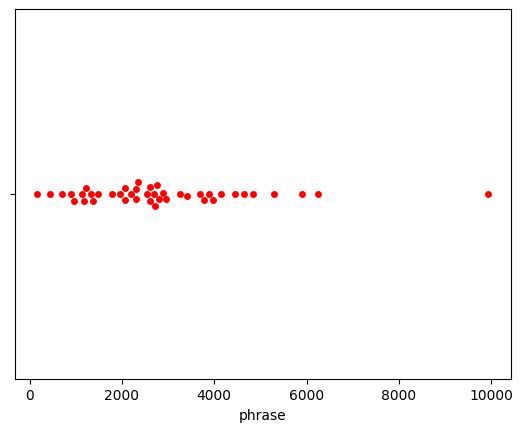

In [35]:
# 1-D swarmplot
sns.swarmplot(x=clusters_count['phrase'], color="red")

In [36]:

#print(clusters.sort_values(by=['cluster']))
# find the centroids
original_space_centroids = lsa[0].inverse_transform(model.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

# for i in range(10):
#     print("#Cluster TOP %d" % (i+1)),
#     print("Cluster %d:" % clusters_count.index[i])

#     for ind in order_centroids[clusters_count.index[i], :10]:
#         print(" %s" % terms[ind])

for i in range(choosen_k):
    print("Cluster %d:" % i),
    print("Cluster size: %d" % clusters_count[clusters_count.index == i].values[0][0])
    for ind in order_centroids[i, :10]:
        print(" %s" % terms[ind])
    print("------------------------------------------")

    for phr in clusters[clusters['cluster']==i]['phrase'].unique()[:20]:
        print("  %s" % phr)
    print("\n")


Cluster 0:
Cluster size: 3785
 deslocamento
 realizado
 diarias
 necessario
 prazo
 realizada
 recurso
 proposto
 inferior
 portaria
------------------------------------------
  necessario esperar homologacao banca pcdp
  motorista oficial devolucao veiculo van emprestada unidade uso rae srrf unidade necessidade veiculo deslocamento servidores
  despacho devidamente anexado informa esclareco motivo pedido proposto antecedencia minimum deu razao tramite processo objetivava pagamento inscricoes servidores reprogramacao escala deslocamento objetivo reduzir diarias solicitadas
  proposto direito receber acrescimo deslocamento art s decreto julho anexar homologada
  confirmacao agenda sr ministro ocorreu decorrer deslocamento
  recebimento recurso financeiro diretrizes atuacao realizado inferior deslocamento ordem servico
  portaria novembro estabelece procedimentos concessao diarias passagens servico ambito ibama art s encaminhamento pcdp ensejar necessidade emissao bilhete aereo realizado

In [37]:
#http://datamining.rutgers.edu/publication/internalmeasures.pdf

## Silhouette Coefficient

In [41]:
metrics.silhouette_score(X, labels, metric='euclidean', sample_size=120000, random_state=42)

0.18898173527458106

## Calinski-Harabasz Index

In [39]:
metrics.calinski_harabasz_score(X, labels)

2715.4421514287615

## Davies-Bouldin Index

In [40]:
metrics.davies_bouldin_score(X, labels)

2.119553678378614